In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, SpectralClustering
from scipy import stats
from random import sample, choices

import ot
import os
import tqdm


In [4]:
data_1 = pd.read_csv('../data/A_2D_1ps.dat', sep=' ', header=None, skipinitialspace=True)
data_1 = np.array(data_1)
data   = data_1

data_shifted = np.loadtxt("../data/ADP_2D.txt")

phi = data_shifted[0:100000,0]
psi = data_shifted[0:100000,1]
#consider only first 100000 pts
data_shifted= np.stack((phi,psi), axis=-1)

reg_wass_psi_w_250_s_250 = np.loadtxt("reg_wass_psi_w_250_s_250.txt").astype(int)

#change_points = reg_wass_psi_w_250_s_250
change_points = [i for i in reg_wass_psi_w_250_s_250 if i < 100000]
bs = 500 #bin size

#### Compute mean and variance of empirical CDF's between change points

### Need to center the CDF's

def construct_mat(data, change_points, bs):
    indexes  = []
    values   = []
    ECDF     = []
    Mean_var = []
    ECDF_MV  = []
    Centered_CDFS = []

    for i in range(len(change_points)):
        if i!=0 and i < len(change_points)-1:
            prev_cp = change_points[i]
            curr_cp = change_points[i+1]
        elif i==0:
            prev_cp = 0
            curr_cp = change_points[i+1]
        else:
            prev_cp = change_points[i]
            curr_cp = 100000
        
        ind_val_pair = sample(list(enumerate(data[prev_cp:curr_cp, 1])), bs)
        ind  = []
        vals = []
        for idx, val in ind_val_pair:
            ind.append(idx+prev_cp)
            vals.append(val)

        ecdf      = np.sort(vals)
        mean, var = np.mean(ecdf), np.var(ecdf)
        ecdf_1    = np.append(ecdf, [mean, var])

        indexes.append(ind)
        values.append(vals)
        ECDF.append(ecdf)
        Centered_CDFS.append(ecdf-mean)
        Mean_var.append([mean, var])
        ECDF_MV.append(ecdf_1)

    return indexes, values, ECDF, Mean_var, ECDF_MV, Centered_CDFS

indexes, values, ECDF, Mean_var, ECDF_MV, Centered = construct_mat(data_shifted, change_points, bs)

print(np.shape(indexes))
print(np.shape(values))
print(np.shape(ECDF))
print(np.shape(Mean_var))
print(np.shape(ECDF_MV))
print(np.shape(Centered))

(48, 500)
(48, 500)
(48, 500)
(48, 2)
(48, 502)
(48, 500)


In [5]:

def plot(data, change_points, labels, Centered, ECDF, file):
    
    
    dict = {0:'b', 1:'k', 2:'r', 3:'c', 4:'m', 5:'y', 6:'g', 7:'orange'}

    fig, (ax1, ax2, ax3)= plt.subplots(3, 1,figsize=(20, 8))
    ax1.plot(np.arange(100000), data[0:100000], 'r', alpha=0.25)
    ax1.vlines(change_points, -2500,3000, alpha=0.5,linestyles='dashed',linewidth=0.5)

    for i in range(len(change_points)):
        if i!=0 and i < len(change_points)-1:
            prev_cp = change_points[i]
            curr_cp = change_points[i+1]
        elif i==0:
            prev_cp = 0
            curr_cp = change_points[i+1]
        else:
            prev_cp = change_points[i]
            curr_cp = 50000
        
        label_1 = labels[i]
        ind = change_points[i]
        ax1.plot(np.arange(prev_cp, curr_cp), data[prev_cp:curr_cp], dict[label_1])
        ax2.plot(Centered[i],np.arange(bs),dict[label_1])
        ax3.plot(ECDF[i],np.arange(bs),dict[label_1])

    ax1.set_title("Dihedral Angle \u03C8")
    ax2.set_title("Centered Empirical CDF's")
    ax3.set_title("Empirical CDF's")

    if file == 0:
        pass
    else:
        plt.savefig(file)
    plt.show()
    return labels

def plt_cdfs(labels, Centered, ECDF, file):
    
    dict = {0:'b', 1:'k', 2:'r', 3:'c', 4:'m', 5:'y', 6:'g', 7:'orange'}

    fig, ax = plt.subplots(8, 2, figsize=(20, 15))

    for i in range(len(labels)):
        label_1=labels[i]
        ax[label_1,0].plot(ECDF[i],np.arange(bs),dict[label_1])
        
        ax[label_1,1].plot(Centered[i],np.arange(bs),dict[label_1])
        ax[label_1,1].set_xlim(-700,700)

    if file == 0:
        pass
    else:
        plt.savefig(file)
    plt.show()

In [6]:
# 1: Construct distance matrix between datapts (metrics: 'euclidean', 'correlation', 'chebyshev')
#To implement: KS statistic, Earth movers distance
def dist_mtx(data, metric):
    if metric=='wass':
        return cdist(data, data, lambda u, v: ot.emd2_1d(u, v))
    else:
        return cdist(data, data, metric)
        
# 2: Create similarity matrix using either KNN or fully_connected
def nearest_nbs(distances, k):
    KNN = NearestNeighbors(n_neighbors=k, metric='precomputed', n_jobs=-1).fit(distances) 
    G = KNN.kneighbors_graph(distances,  mode='distance').toarray()
    newG = np.diag(G)
    Affinity= G - np.diag(newG)
    return Affinity

def Gaussian_kernel(distances):
    sigma = 0.75*np.mean(distances[distances>0])
    return np.exp(-(distances**2 / (sigma**2)))

# 3: Construct graph laplacian
def check_symmetric(a, tol=1e-2):
    return np.all(np.abs(a-a.T) < tol)

def Laplacian(mat, GK):
    if GK==True:
        reciprocal_matrix=mat
    else:
        #Turn mat into 1/mat because we want far points to have cheap cuts and close points to be expensive (only for regular distance matrix though)
        with np.errstate(divide='ignore', invalid='ignore'):
            reciprocal_matrix = np.where(mat != 0, 1 / mat, 0)
    
    diag_vals = np.sum(reciprocal_matrix, axis=1)
    D = np.diag(diag_vals)
    L = D - reciprocal_matrix
    #Check if Laplacian is symmetric:
    if check_symmetric(L):
        return L
    else:
        print('Laplacian is not symmetric')

# 4: Eigendecompose Laplacian
def eigs(lap):
    eigenvalues, eigenvectors = np.linalg.eig(lap)
    
    eigenvalues = np.real(eigenvalues)
    eigenvectors = np.real(eigenvectors)
    sorted_indexes = np.argsort(eigenvalues)
    
    eigenvalues = eigenvalues[sorted_indexes]
    eigenvectors = eigenvectors[:,sorted_indexes]

    eigenvecs = [np.real(eigenvectors[i]) for i in range(len(eigenvectors))]
    diffs = [np.abs(eigenvalues[i+1] - eigenvalues[i]) for i in range(len(eigenvalues)-1)]
    eigen_gap = np.argmax(diffs) + 1

    fig, (ax1, ax2, ax3)= plt.subplots(1, 3,figsize=(15,4))
    ax1.scatter(np.arange(len(eigenvalues)), eigenvalues, alpha=0.7)
    ax1.set_title("eigenvalues")
    ax2.scatter(np.arange(len(eigenvecs)), eigenvecs[0])
    ax2.set_title("components of first eigenvector")
    ax3.scatter(np.arange(len(eigenvecs)), eigenvecs[1])
    ax3.set_title("components of second eigenvector")
    
    return eigenvecs, eigen_gap

# 5: K-means cluster the eigenvectors corresponding to smallest nonzero eigenvalues
def get_clusters(X,k):
    Kmeans = KMeans(max_iter=1000, n_clusters=k)
    Kmeans.fit(X)
    return Kmeans.labels_

# 6: Spectral Embedding
def embedding(eigen_vec, labels):
    fig, ax = plt.subplots()
    for i in range(len(eigen_vec)):
        ax.scatter(eigen_vec[i][1], eigen_vec[i][2])
    if len(labels) == 0:
        pass
    else:
        dict = {0:'b', 1:'k', 2:'r', 3:'c', 4:'m', 5:'y', 6:'g', 7:'orange'}
        for i in range(len(eigen_vec)):
            ax.scatter(eigen_vec[i][1], eigen_vec[i][2], c=dict[labels[i]], s=20, alpha=0.7)

47


/usr/local/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


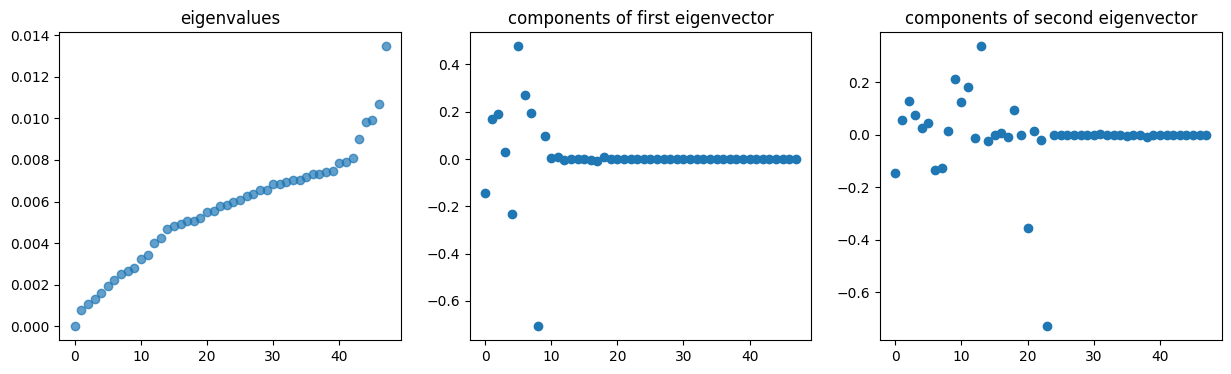

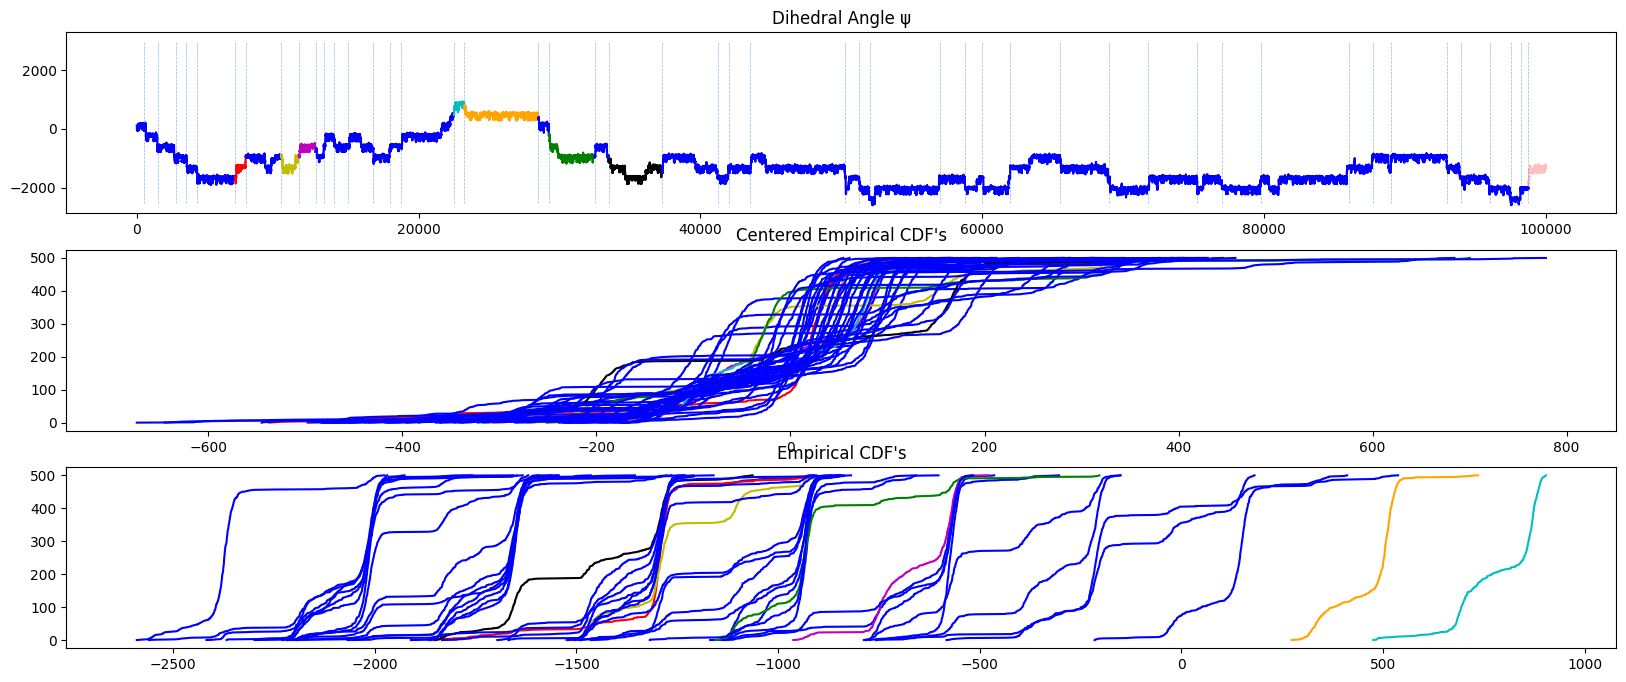

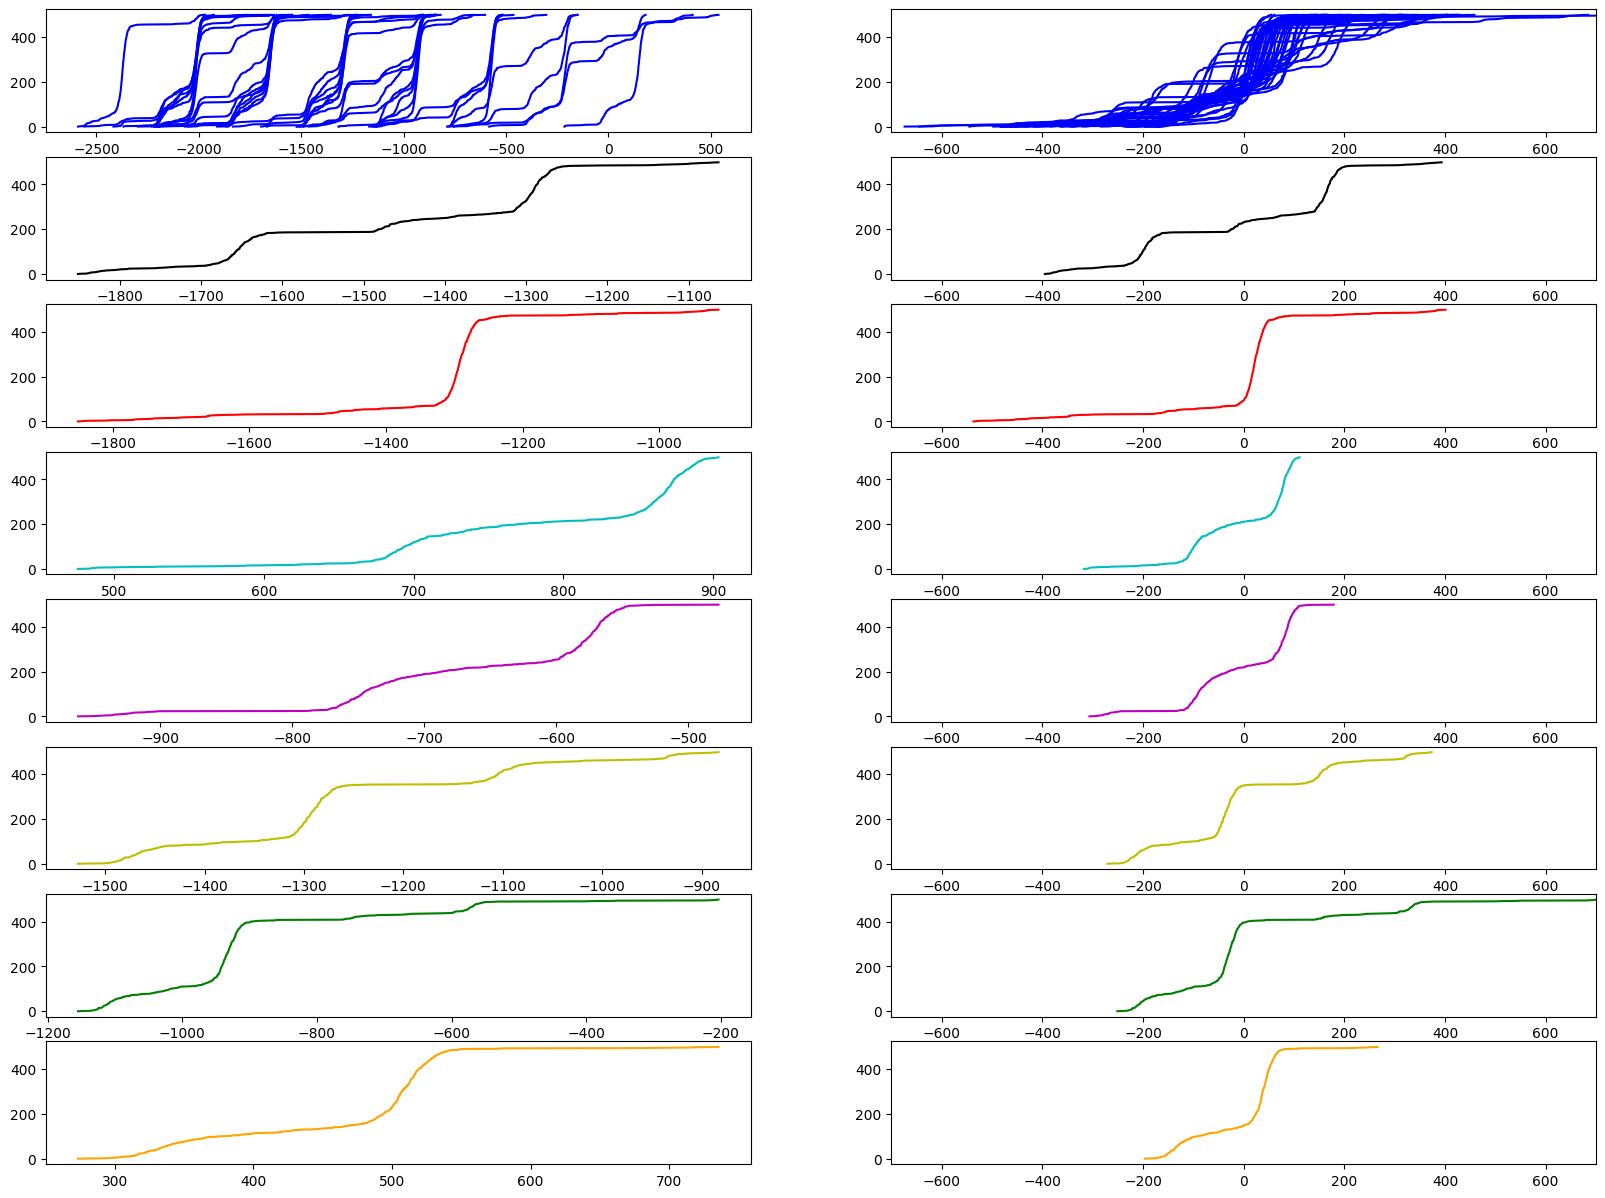

In [7]:
dists = dist_mtx(ECDF, 'euclidean')
nbs = nearest_nbs(dists, 30)
lap = Laplacian(nbs,False)
eig_vec, num_clusters = eigs(lap)
print(num_clusters)
labels = get_clusters(eig_vec, 8)
plot(data_shifted[:,1], change_points,labels, Centered, ECDF, 0)
plt_cdfs(labels, Centered, ECDF,0)
#embedding(eig_vec, labels)

# Centered - KNN - Euclidean

1


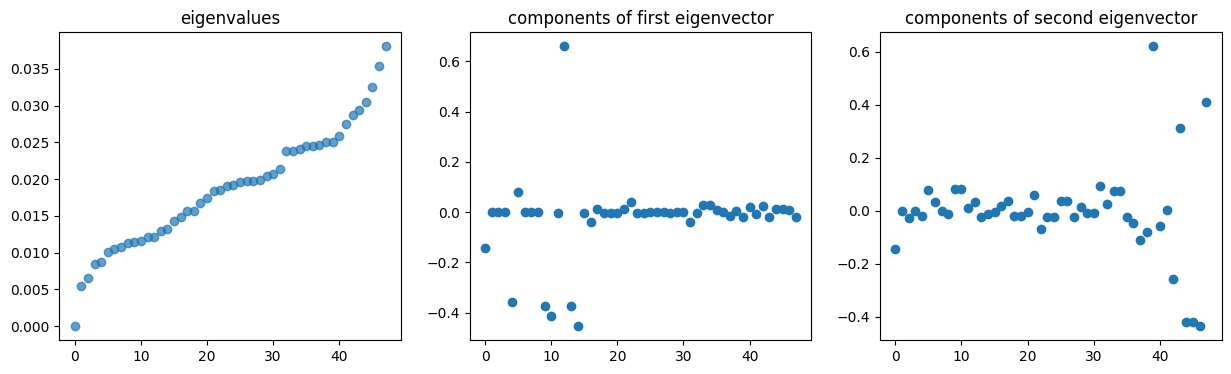

In [77]:
dists = dist_mtx(Centered, 'euclidean')
nbs = nearest_nbs(dists, 21)
lap = Laplacian(nbs,False)
eig_vec, num_clusters = eigs(lap)
print(num_clusters)


# Centered - Fully Connected (With Gaussian Kernel) - Wass

11


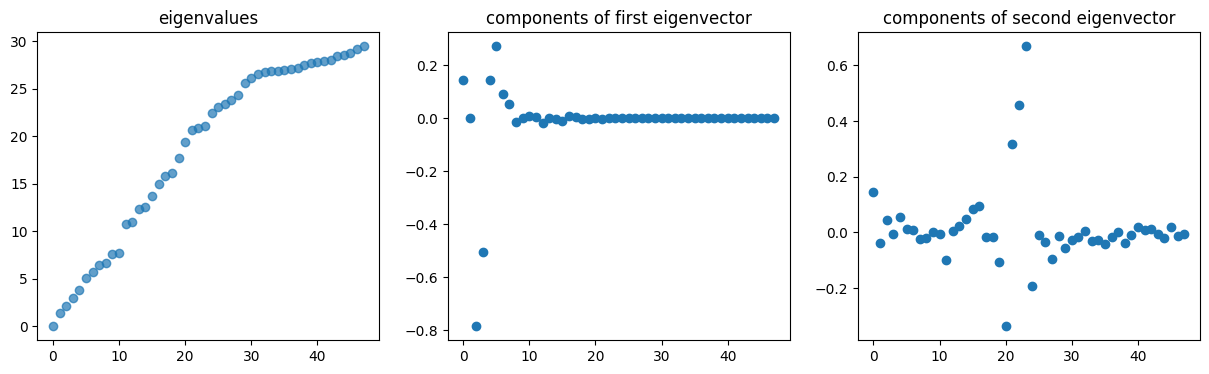

In [8]:
dists = dist_mtx(Centered, 'wass')
nbs = Gaussian_kernel(dists)
lap = Laplacian(nbs, True)
eig_vec, num_clusters = eigs(lap)
print(num_clusters)


# Centered - Fully Connected (With Gaussian Kernel) - Euclidean

19


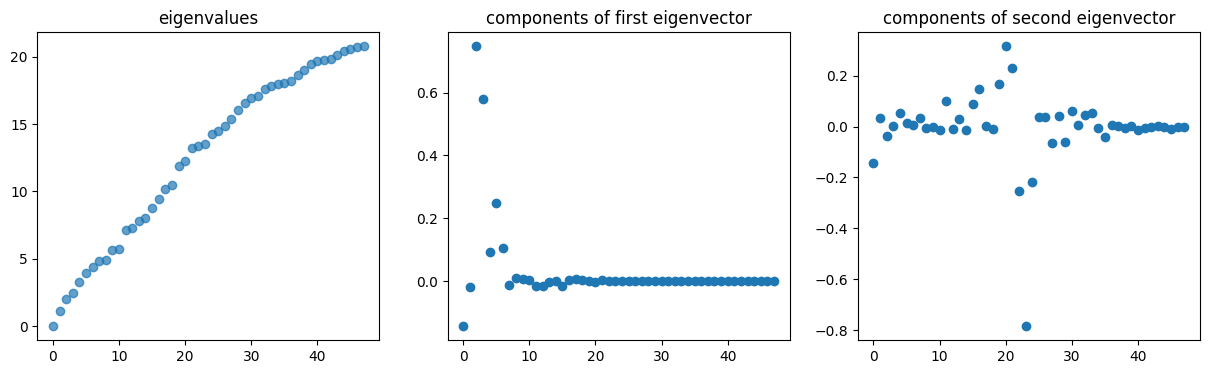

In [9]:
dists = dist_mtx(Centered, 'euclidean')
nbs = Gaussian_kernel(dists)
lap = Laplacian(nbs, True)
eig_vec, num_clusters = eigs(lap)
print(num_clusters)

In [10]:
def run_knn(k):
    IMG_FOLDER = './images_clst'
    for i in range(5):
        xs1 = ["run ", str(i), " n_neighbors = ", str(k), ".png"]
        xs2 = ["sep run ", str(i), " n_neighbors = ", str(k), ".png"]
        s1 = ''.join(xs1)
        s2 = ''.join(xs2)
        path1 = os.path.join(IMG_FOLDER, s1)
        path2 = os.path.join(IMG_FOLDER, s2)
        
        dists = dist_mtx(Centered, 'chebyshev')
        nbs = nearest_nbs(dists, k)
        lap = Laplacian(nbs,False)
        eig_vec, gap = eigs(lap)
        labels = get_clusters(eig_vec, 8)

        ##
        plot(data_shifted[:,1], change_points,labels, Centered, ECDF, path1)
        plt_cdfs(labels, Centered, ECDF,path2)

def run_gauss():
    IMG_FOLDER = './images_clst'
    for i in range(10):
        xs1 = ["run ", str(i), " gauss.png"]
        xs2 = ["sep run ", str(i), " gauss.png"]
        s1 = ''.join(xs1)
        s2 = ''.join(xs2)
        path1 = os.path.join(IMG_FOLDER, s1)
        path2 = os.path.join(IMG_FOLDER, s2)
        
        dists = dist_mtx(Centered, 'chebyshev')
        nbs = Gaussian_kernel(dists)
        lap = Laplacian(nbs,True)
        eig_vec, gap = eigs(lap)
        labels = get_clusters(eig_vec, 8)

        ##
        plot(data_shifted[:,1], change_points,labels, Centered, ECDF, path1)
        plt_cdfs(labels, Centered, ECDF,path2)


In [ ]:
for k in range(10,45, 1):
    run_knn(k)

In [ ]:
run_gauss()

In [15]:
arr = np.array([[1, 1], [2, 2]])
arr[1, 0:2]

array([2, 2])